In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


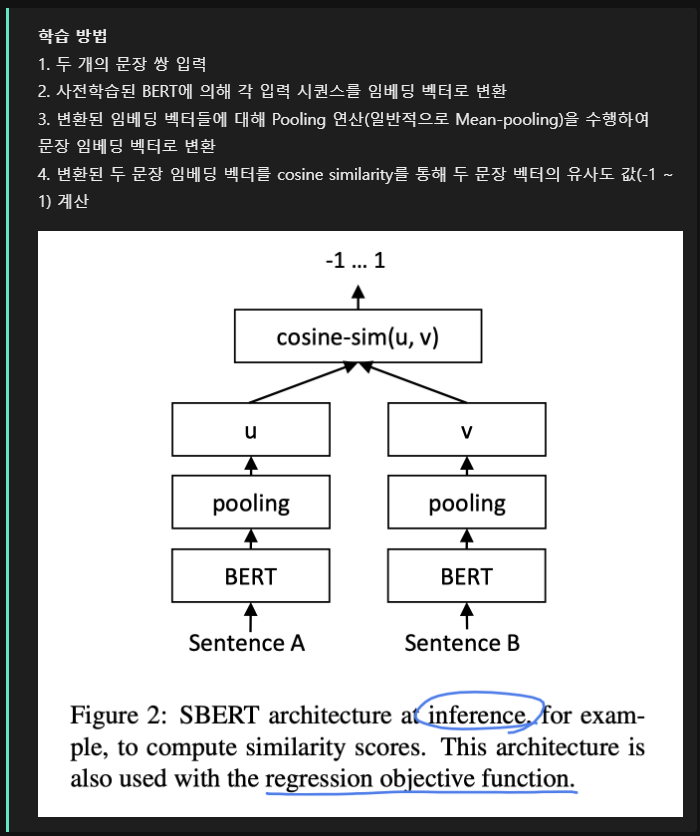

In [ ]:
# 본인의 실습 디렉토리로 변경
% cd /content/drive/MyDrive/Dev/my_workspace/NLP/sentence-transformers/bi-encoder-training

/content/drive/MyDrive/Dev/my_workspace/NLP/sentence-transformers


In [ ]:
! pip install sentence_transformers datasets

     |████████████████████████████████| 79 kB 3.8 MB/s 
     |████████████████████████████████| 311 kB 11.7 MB/s 
     |████████████████████████████████| 3.5 MB 41.3 MB/s 
     |████████████████████████████████| 1.2 MB 41.4 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
     |████████████████████████████████| 895 kB 45.2 MB/s 
     |████████████████████████████████| 6.8 MB 37.8 MB/s 
     |████████████████████████████████| 596 kB 44.4 MB/s 
     |████████████████████████████████| 1.1 MB 43.4 MB/s 
     |████████████████████████████████| 212 kB 56.3 MB/s 
     |████████████████████████████████| 134 kB 46.8 MB/s 
     |████████████████████████████████| 271 kB 49.7 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 144 kB 51.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=22b1ca94a1a3300cda2a36ef381396299490cc638acccd83d903153316f898de
  Stored in d

In [ ]:
import math
import logging
from datetime import datetime

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, models, LoggingHandler, losses, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import InputExample

In [ ]:
# logger
logging.basicConfig(
    format="%(asctime)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.INFO,
    handlers=[LoggingHandler()],
)

In [ ]:
pretrained_model_name = 'klue/roberta-base'
sts_num_epochs = 4
train_batch_size = 32

sts_model_save_path = 'output/training_sts-'+pretrained_model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# 1. Load Dataset & Preprocessing

## 1.1. KLUE-STS

In [ ]:
# load KLUE-STS Dataset
klue_sts_train = load_dataset("klue", "sts", split='train[:90%]')
klue_sts_valid = load_dataset("klue", "sts", split='train[-10%:]') # train의 10%를 validation set으로 사용
klue_sts_test = load_dataset("klue", "sts", split='validation')

print('Length of Train : ',len(klue_sts_train))
print('Length of Valid : ',len(klue_sts_valid))
print('Length of Test : ',len(klue_sts_test))

Downloading:   0%|          | 0.00/5.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.93k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset klue downloaded and prepared to /root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e. Subsequent calls will reuse this data.
2022-02-25 01:53:32 - Reusing dataset klue (/root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e)
2022-02-25 01:53:32 - Reusing dataset klue (/root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e)
Length of Train :  10501
Length of Valid :  1167
Length of Test :  519


In [ ]:
klue_sts_train[0]

{'guid': 'klue-sts-v1_train_00000',
 'labels': {'binary-label': 1, 'label': 3.7, 'real-label': 3.714285714285714},
 'sentence1': '숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.',
 'sentence2': '숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.',
 'source': 'airbnb-rtt'}

In [ ]:
def make_sts_input_example(dataset):
    '''
    Transform to InputExample
    '''
    input_examples = []
    for i, data in enumerate(dataset):
        sentence1 = data['sentence1']
        sentence2 = data['sentence2']
        score = (data['labels']['label']) / 5.0  # normalize 0 to 5
        input_examples.append(InputExample(texts=[sentence1, sentence2], label=score))

    return input_examples

In [ ]:
sts_train_examples = make_sts_input_example(klue_sts_train)
sts_valid_examples = make_sts_input_example(klue_sts_valid)
sts_test_examples = make_sts_input_example(klue_sts_test)

In [ ]:
# Train Dataloader
train_dataloader = DataLoader(
    sts_train_examples,
    shuffle=True,
    batch_size=train_batch_size,
)

# Evaluator by sts-validation
dev_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
    sts_valid_examples,
    name="sts-dev",
)

# Evaluator by sts-test
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
    sts_test_examples,
    name="sts-test",
)

# 2. Load Embedding Model

In [ ]:
# Load Embedding Model
embedding_model = models.Transformer(
    model_name_or_path=pretrained_model_name,
    max_seq_length=256,
    do_lower_case=True
)

# Only use Mean Pooling -> Pooling all token embedding vectors of sentence.
pooling_model = models.Pooling(
    embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False,
)

model = SentenceTransformer(modules=[embedding_model, pooling_model])

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

2022-02-25 01:53:27 - Use pytorch device: cuda


# 3. STS training

In [ ]:
# Use CosineSimilarityLoss
train_loss = losses.CosineSimilarityLoss(model=model)

# warmup steps
warmup_steps = math.ceil(len(sts_train_examples) * sts_num_epochs / train_batch_size * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

# Training
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=dev_evaluator,
    epochs=sts_num_epochs,
    evaluation_steps=int(len(train_dataloader)*0.1),
    warmup_steps=warmup_steps,
    output_path=sts_model_save_path
)

2022-02-25 01:53:34 - Warmup-steps: 132


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/329 [00:00<?, ?it/s]

2022-02-25 01:59:03 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 0:
2022-02-25 01:59:12 - Cosine-Similarity :	Pearson: 0.9549	Spearman: 0.9113
2022-02-25 01:59:12 - Manhattan-Distance:	Pearson: 0.9498	Spearman: 0.9126
2022-02-25 01:59:12 - Euclidean-Distance:	Pearson: 0.9499	Spearman: 0.9123
2022-02-25 01:59:12 - Dot-Product-Similarity:	Pearson: 0.9456	Spearman: 0.8933
2022-02-25 01:59:12 - Save model to output/training_sts_continue_training-klue-roberta-base-2022-02-25_01-53-00


Iteration:   0%|          | 0/329 [00:00<?, ?it/s]

2022-02-25 02:04:31 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 1:
2022-02-25 02:04:40 - Cosine-Similarity :	Pearson: 0.9615	Spearman: 0.9218
2022-02-25 02:04:40 - Manhattan-Distance:	Pearson: 0.9566	Spearman: 0.9207
2022-02-25 02:04:40 - Euclidean-Distance:	Pearson: 0.9568	Spearman: 0.9210
2022-02-25 02:04:40 - Dot-Product-Similarity:	Pearson: 0.9552	Spearman: 0.9085
2022-02-25 02:04:40 - Save model to output/training_sts_continue_training-klue-roberta-base-2022-02-25_01-53-00


Iteration:   0%|          | 0/329 [00:00<?, ?it/s]

2022-02-25 02:09:58 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 2:
2022-02-25 02:10:07 - Cosine-Similarity :	Pearson: 0.9628	Spearman: 0.9229
2022-02-25 02:10:07 - Manhattan-Distance:	Pearson: 0.9569	Spearman: 0.9218
2022-02-25 02:10:07 - Euclidean-Distance:	Pearson: 0.9570	Spearman: 0.9219
2022-02-25 02:10:07 - Dot-Product-Similarity:	Pearson: 0.9543	Spearman: 0.9065
2022-02-25 02:10:07 - Save model to output/training_sts_continue_training-klue-roberta-base-2022-02-25_01-53-00


Iteration:   0%|          | 0/329 [00:00<?, ?it/s]

2022-02-25 02:15:28 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 3:
2022-02-25 02:15:37 - Cosine-Similarity :	Pearson: 0.9636	Spearman: 0.9253
2022-02-25 02:15:37 - Manhattan-Distance:	Pearson: 0.9578	Spearman: 0.9238
2022-02-25 02:15:37 - Euclidean-Distance:	Pearson: 0.9578	Spearman: 0.9240
2022-02-25 02:15:37 - Dot-Product-Similarity:	Pearson: 0.9564	Spearman: 0.9106
2022-02-25 02:15:37 - Save model to output/training_sts_continue_training-klue-roberta-base-2022-02-25_01-53-00


# 4. Evaluation

In [ ]:
# evaluation sts-test
test_evaluator(model, output_path=sts_model_save_path)

2022-02-25 02:15:39 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-test dataset:
2022-02-25 02:15:43 - Cosine-Similarity :	Pearson: 0.8870	Spearman: 0.8873
2022-02-25 02:15:43 - Manhattan-Distance:	Pearson: 0.8862	Spearman: 0.8835
2022-02-25 02:15:43 - Euclidean-Distance:	Pearson: 0.8869	Spearman: 0.8844
2022-02-25 02:15:43 - Dot-Product-Similarity:	Pearson: 0.8775	Spearman: 0.8745


0.887279591001845